In [2]:
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *

from sklearn.model_selection import train_test_split 

from lumin.plotting.data_viewing import plot_rank_order_dendrogram
from lumin.optimisation.features import rf_rank_features
from rfpimp import plot_corr_heatmap, feature_dependence_matrix, plot_dependence_heatmap
from sklearn.ensemble import RandomForestRegressor

In [3]:
DATA_PATH = Path('../data')

In [4]:
!python ../modules/data_import.py -d ../data/

Converting to use_cartesian coordinates
Converting to use_cartesian coordinates
Training on 200000 datapoints and validating on 50000, using 31 feats:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_met_pt']
Saving fold 0 with 20001 events
Saving fold 1 with 20001 events
Saving fold 2 with 20001 events
Saving fold 3 with 20001 events
Saving fold 4 with 20000 events
Saving fold 5 with 20000 events
Saving fold 6 with 19999 events
Saving fold 7 with 19999 events
Saving 

In [16]:
train_fy = FoldYielder(DATA_PATH/'train.hdf5', input_pipe=DATA_PATH/'input_pipe.pkl')
train_df = train_fy.get_df(inc_inputs=True, deprocess=True, suppress_warn=True, nan_to_num=True); train_df.head()

200000 datapoints loaded


,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_met_px,PRI_met_py,PRI_lep_px,PRI_lep_py,PRI_lep_pz,PRI_met_pt,gen_target,gen_weight
0,118.603996,11.091999,54.427002,202.108002,4.042,593.971008,-1.648,1.560,50.736000,287.677002,...,65.123001,-50.432621,107.143608,-79.108940,34.886433,-34.100079,0.146352,133.184006,1,0.000003
1,238.871002,75.789001,189.103989,12.648002,0.000,0.000000,0.000,3.315,12.648000,141.125000,...,0.000000,0.000000,21.598518,3.198051,-64.580902,32.853062,74.170792,21.834000,0,0.000016
2,90.885002,32.128998,57.873001,94.754997,0.000,0.000000,0.000,1.683,29.142000,140.067001,...,25.429691,8.417485,37.891876,-8.952106,11.039382,-28.479256,7.149947,38.935001,0,0.000005
3,109.030998,36.539001,60.702000,90.041000,0.000,0.000000,0.000,2.080,42.842003,128.291992,...,31.350780,1486.360229,29.392572,-41.189053,29.838301,0.835691,22.756226,50.601002,1,0.000003
4,81.420006,50.828999,61.978001,18.033001,0.000,0.000000,0.000,2.730,18.033001,64.590004,...,0.000000,0.000000,-21.064674,15.216825,30.612186,25.111330,11.355269,25.986000,0,0.000014


In [21]:
train_feats = train_fy.cont_feats+train_fy.cat_feats

In [22]:
vec_feats = []
for c in ['px', 'py', 'pz']:
    vec_feats += [f for f in train_feats if f == f'{f[:f.rfind("_")+1]}{c}']
len(vec_feats)

14

In [23]:
vec_feats

['PRI_tau_px',
 'PRI_jet_subleading_px',
 'PRI_jet_leading_px',
 'PRI_met_px',
 'PRI_lep_px',
 'PRI_tau_py',
 'PRI_jet_subleading_py',
 'PRI_jet_leading_py',
 'PRI_met_py',
 'PRI_lep_py',
 'PRI_tau_pz',
 'PRI_jet_subleading_pz',
 'PRI_jet_leading_pz',
 'PRI_lep_pz']

In [24]:
hl_feats = [f for f in train_feats if f.startswith('DER_')]; len(hl_feats)

13

In [25]:
ll_feats = [f for f in train_feats if f.startswith('PRI_')]; len(ll_feats)

18

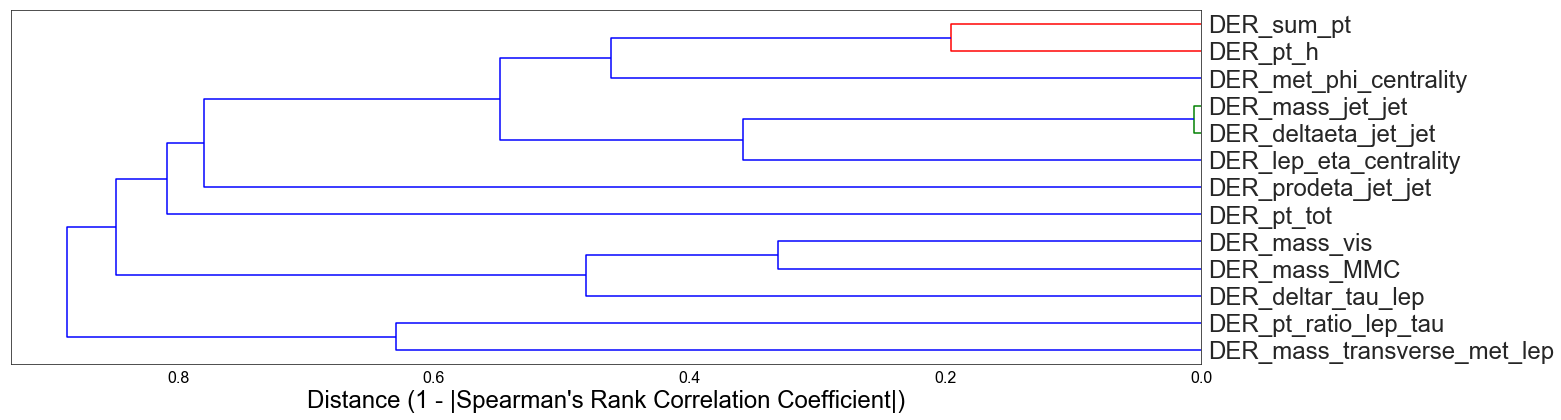

[['DER_deltaeta_jet_jet', 'DER_mass_jet_jet'], ['DER_pt_h', 'DER_sum_pt']]

In [26]:
plot_rank_order_dendrogram(train_df[hl_feats], savename='plots/dendro')

In [27]:
df_trn, df_val = train_test_split(train_df, test_size=0.2, random_state=0, stratify=train_df.gen_target)

Optimising RF parameters


Evalualting importances
Top ten most important features:
                        Feature  Importance
0  DER_mass_transverse_met_lep    0.115878
1                 DER_mass_MMC    0.107649
2                 DER_mass_vis    0.053357
3       DER_met_phi_centrality    0.034936
4         DER_pt_ratio_lep_tau    0.031064
5           DER_deltar_tau_lep    0.025127
6                   DER_sum_pt    0.020437
7                     DER_pt_h    0.019639
8                   DER_pt_tot    0.012748
9       DER_lep_eta_centrality    0.002081


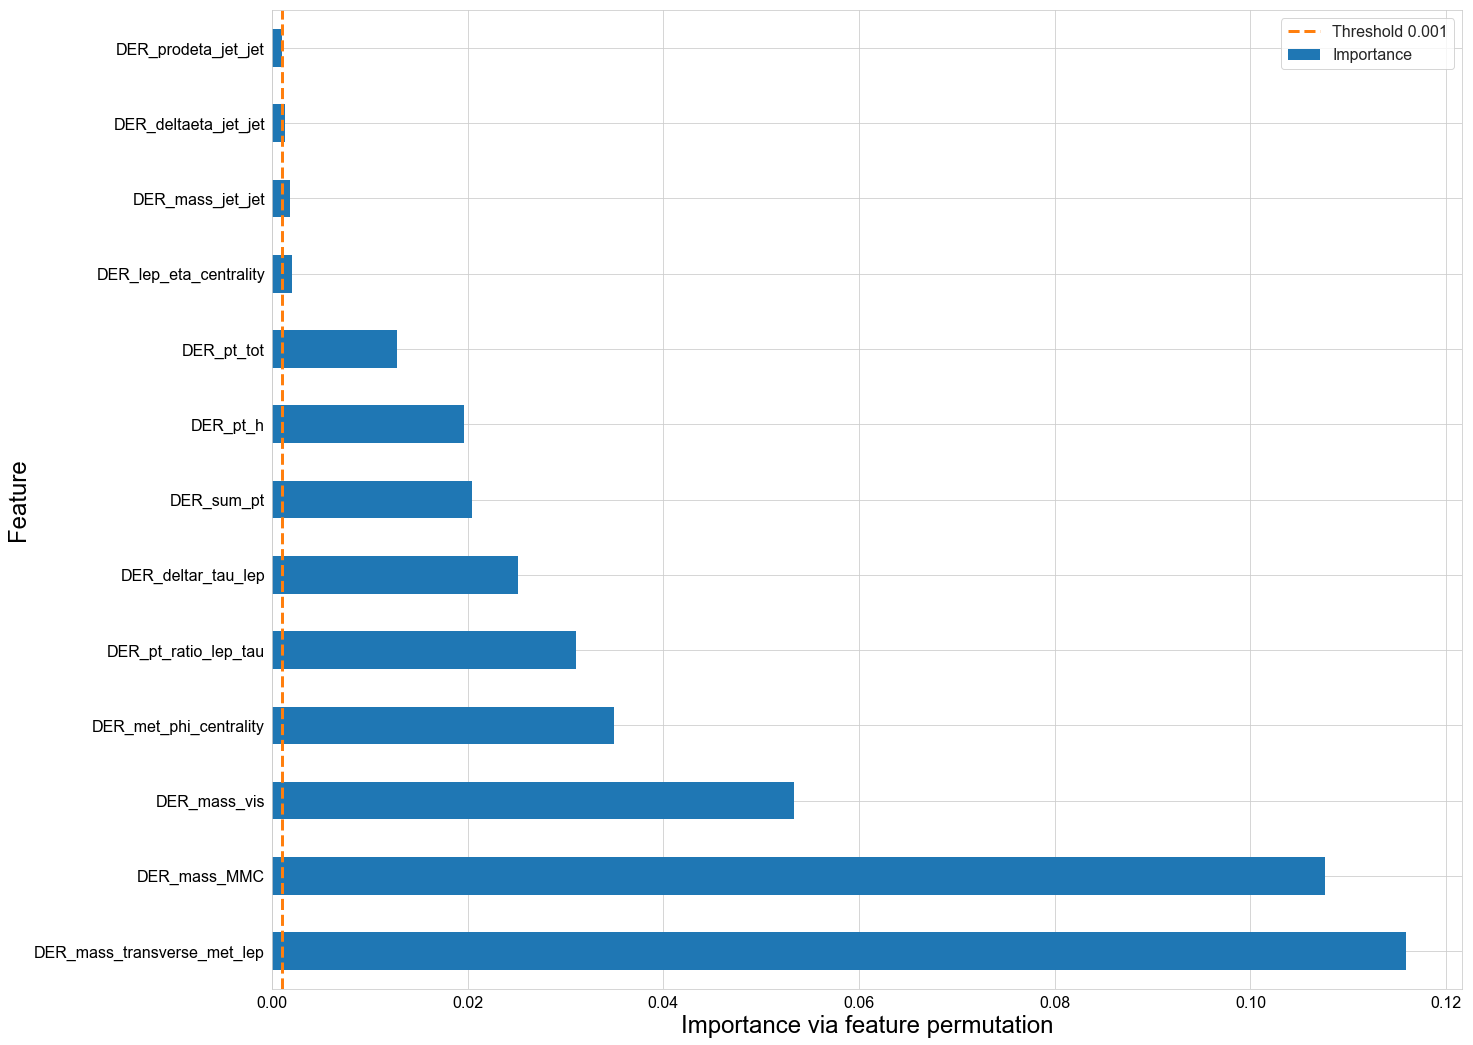


13 features found with importance greater than 0.001:
 ['DER_mass_transverse_met_lep', 'DER_mass_MMC', 'DER_mass_vis', 'DER_met_phi_centrality', 'DER_pt_ratio_lep_tau', 'DER_deltar_tau_lep', 'DER_sum_pt', 'DER_pt_h', 'DER_pt_tot', 'DER_lep_eta_centrality', 'DER_mass_jet_jet', 'DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet'] 

All training features found to be important


In [28]:
import_feats = rf_rank_features(df_trn, df_val, objective='classification', train_feats=hl_feats, wgt_name='gen_weight', importance_cut=0.001, savename='plots/hl_imp', plot_settings=plot_settings)

In [29]:
[f for f in train_feats if f not in import_feats]

['PRI_met_sumet',
 'PRI_jet_num',
 'PRI_jet_all_pt',
 'PRI_tau_px',
 'PRI_tau_py',
 'PRI_tau_pz',
 'PRI_jet_subleading_px',
 'PRI_jet_subleading_py',
 'PRI_jet_subleading_pz',
 'PRI_jet_leading_px',
 'PRI_jet_leading_py',
 'PRI_jet_leading_pz',
 'PRI_met_px',
 'PRI_met_py',
 'PRI_lep_px',
 'PRI_lep_py',
 'PRI_lep_pz',
 'PRI_met_pt']

In [34]:
hl_feats = [f for f in hl_feats if 'jet_jet' not in f and f != 'DER_lep_eta_centrality']

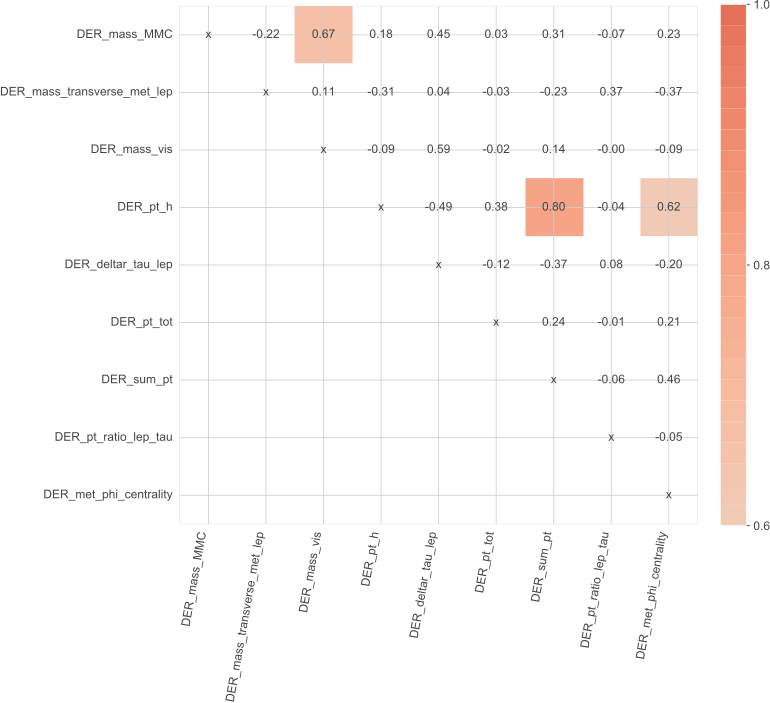

In [35]:
plot_corr_heatmap(df_trn[hl_feats], figsize=(11,11), label_fontsize=12, value_fontsize=12)#.save('plots/hl_col.pdf')

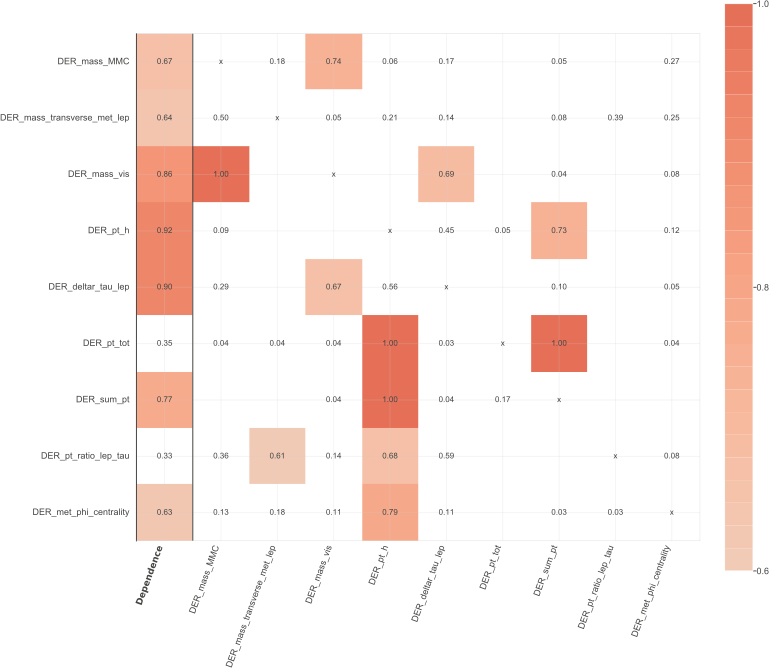

In [36]:
D = feature_dependence_matrix(df_trn[hl_feats], sort_by_dependence=False, rfmodel=RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True))
plot_dependence_heatmap(D, figsize=(11,10))#.save('plots/hl_dep.pdf')